In [ ]:
#####################################################################################################################
# Inferring Temporal Logic Specifications for Robot-Assisted Feeding in Social Dining Settings
#
# Jan Ondras (janko@cs.cornell.edu, jo951030@gmail.com)
# Project for Program Synthesis (CS 6172)
# Cornell University, Fall 2021
#####################################################################################################################
# Plot results from LoTuS cross-validation for maximum tree depth of 3
#####################################################################################################################

In [3]:
# Load data

import numpy as np
import time
import pickle
import json
import matplotlib.pyplot as plt
from tabulate import tabulate
from IPython.display import display, Math


feature_sources = [
    'solo',
    'duo',
    # 'trio'
]
primitives_sets = [
    'setPrim1',
    'setPrim2',
    'setPrim12'
]

res = {}
for feature_source in feature_sources:
    res[feature_source] = {}
    for primitives_set in primitives_sets:
        with open(f'./cv_results/cv_results_{feature_source}_{primitives_set}_3.pkl', 'rb') as f:
        with open(f'./cv_results/cv_results_{feature_source}_{primitives_set}_3_compareWindows.pkl', 'rb') as f:
            res[feature_source][primitives_set] = pickle.load(f)

In [ ]:
# 1.) Optimal window size over feature types for the Solo feature source and the P1 primitives type

import matplotlib

max_tree_depth = 3
# window_size = 60
feature_source = 'solo'
primitives_set = 'setPrim1'

feature_types = [
    # 'tR2',
    'R2',
    'dR2',
    'R2dR2',
    # 'tR2dR2',
]
feature_types_labels = {
    'R2': '$R_2$',
    'dR2': '$dR_2$',
    'R2dR2': '$R_2dR_2$'
}
window_sizes = [15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180, 195, 210]


for partition in ['test']:
    # plt.figure(figsize=[15,6])
    plt.figure()
    for feature_type in feature_types:
        means = np.array([ res[feature_source][primitives_set][feature_type][window_size][max_tree_depth][f'{partition}_mcrs_pruned_mean'] for window_size in window_sizes ])
        stds = np.array([ res[feature_source][primitives_set][feature_type][window_size][max_tree_depth][f'{partition}_mcrs_pruned_std'] for window_size in window_sizes ])
        plt.plot(window_sizes, means, 'o-', label=feature_types_labels[feature_type])
        plt.fill_between(window_sizes,  means - stds,  means + stds, alpha=.2)
    plt.xlabel('Window size (# frames)')
    plt.ylabel(f'{partition.capitalize()} misclassification rate (MCR)')
    plt.xticks(window_sizes, window_sizes)
    # plt.ylim(0, 0.25)
    # plt.ylim(0, 0.4)
    plt.legend()
    plt.show()


In [4]:
# 2.) Print table of test MCR (mean, std)

max_tree_depth = 3
window_size = 60

def get_tab_data(key, with_color_gradient=False):
    columns = [[], [], []]
    for i, primitives_set in enumerate(primitives_sets):
        for feature_source in feature_sources:
            for feature_type in feature_types:
                r = res[feature_source][primitives_set][feature_type][window_size][max_tree_depth]
                mean = f"{r[f'{key}_mean']:.3f}"
                columns[i].append( ("\gradient{" + mean + "}" if with_color_gradient else mean) + f"({r[f'{key}_std']:.3f})")
    return np.concatenate((
        [[f'{feature_types_labels[feature_type][1:-1]}' for feature_source in feature_sources for feature_type in feature_types]],
        [columns[0]], [columns[1]], [columns[2]]
    ), axis=0).T


headers = [
    'Feature source', 'Feature type',
    'P_1', 'P_2', 'P_{12}'
]
feature_sources_labels = [f'{feature_source.capitalize()}' for feature_source in feature_sources for feature_type in feature_types]

print(tabulate(get_tab_data('test_mcrs_pruned'), headers=headers, 
               tablefmt='fancy_grid', 
               showindex=feature_sources_labels, 
               numalign='center'
              ))

# Add color gradients for LaTex
print(tabulate(get_tab_data('test_mcrs_pruned', True), headers=headers, 
               tablefmt='latex_booktabs', 
               showindex=feature_sources_labels, 
               numalign='center'
              ))

╒══════════════════╤════════════════╤══════════════╤══════════════╤══════════════╕
│ Feature source   │ Feature type   │ P_1          │ P_2          │ P_{12}       │
╞══════════════════╪════════════════╪══════════════╪══════════════╪══════════════╡
│ Solo             │ R_2            │ 0.210(0.011) │ 0.221(0.008) │ 0.208(0.010) │
├──────────────────┼────────────────┼──────────────┼──────────────┼──────────────┤
│ Solo             │ dR_2           │ 0.291(0.022) │ 0.283(0.028) │ 0.275(0.017) │
├──────────────────┼────────────────┼──────────────┼──────────────┼──────────────┤
│ Solo             │ R_2dR_2        │ 0.180(0.019) │ 0.209(0.022) │ 0.185(0.019) │
├──────────────────┼────────────────┼──────────────┼──────────────┼──────────────┤
│ Duo              │ R_2            │ 0.371(0.016) │ 0.379(0.014) │ 0.367(0.018) │
├──────────────────┼────────────────┼──────────────┼──────────────┼──────────────┤
│ Duo              │ dR_2           │ 0.463(0.018) │ 0.456(0.015) │ 0.432(0.016) │
├───

In [5]:
# 3.) Print table of decision tree learning times (mean, std)

def get_tab_data(key, with_color_gradient=False):
    columns = [[], [], []]
    for i, primitives_set in enumerate(primitives_sets):
        for feature_source in feature_sources:
            for feature_type in feature_types:
                r = res[feature_source][primitives_set][feature_type][window_size][max_tree_depth]
                mean = f"{r[f'{key}_mean']:.0f}"
                columns[i].append( ("\gradient{" + mean + "}" if with_color_gradient else mean) + f"({r[f'{key}_std']:.0f})")
    return np.concatenate((
        [[f'{feature_types_labels[feature_type][1:-1]}' for feature_source in feature_sources for feature_type in feature_types]],
        [columns[0]], [columns[1]], [columns[2]]
    ), axis=0).T

print(tabulate(get_tab_data('times'), headers=headers, 
               tablefmt='fancy_grid', 
               showindex=feature_sources_labels, 
               numalign='center'
              ))

# Add color gradients for LaTex
print(tabulate(get_tab_data('times', True), headers=headers, 
               tablefmt='latex_booktabs', 
               showindex=feature_sources_labels, 
               numalign='center'
              ))

╒══════════════════╤════════════════╤════════╤═════════╤══════════╕
│ Feature source   │ Feature type   │ P_1    │ P_2     │ P_{12}   │
╞══════════════════╪════════════════╪════════╪═════════╪══════════╡
│ Solo             │ R_2            │ 10(0)  │ 284(11) │ 292(20)  │
├──────────────────┼────────────────┼────────┼─────────┼──────────┤
│ Solo             │ dR_2           │ 9(1)   │ 248(44) │ 251(16)  │
├──────────────────┼────────────────┼────────┼─────────┼──────────┤
│ Solo             │ R_2dR_2        │ 23(2)  │ 531(69) │ 514(41)  │
├──────────────────┼────────────────┼────────┼─────────┼──────────┤
│ Duo              │ R_2            │ 16(1)  │ 399(22) │ 409(22)  │
├──────────────────┼────────────────┼────────┼─────────┼──────────┤
│ Duo              │ dR_2           │ 13(1)  │ 298(16) │ 307(26)  │
├──────────────────┼────────────────┼────────┼─────────┼──────────┤
│ Duo              │ R_2dR_2        │ 47(15) │ 721(49) │ 739(57)  │
╘══════════════════╧════════════════╧════════╧══

In [10]:
# 4.) Print sample formulas

feature_type_to_features = {
    'R2': [r'{}_{i}\theta_p', r'{}_{i}\theta_y', r'{}_{j}\theta_p', r'{}_{j}\theta_y', r'{}_{k}\theta_p', r'{}_{k}\theta_y'],
    # 'dR2': [r'd\theta_p', r'd\theta_y'],
    # 'R2dR2': [r'\theta_p', r'\theta_y', r'd\theta_p', r'd\theta_y']
}

for feature_source in feature_sources:        
    for primitives_set in ['setPrim1']: #, 'setPrim2', 'setPrim12']:
        for feature_type in ['R2']:
            print("=========================================================================\n",primitives_set, feature_source, feature_type)
            # Find shortest/longest formula or iterate over all
            #formula = max(res[feature_source][primitives_set][feature_type][window_size][max_tree_depth]['formulas_pruned'], key=len)
            for formula in res[feature_source][primitives_set][feature_type][window_size][max_tree_depth]['formulas_pruned']:
                # Replace temporal operators
                formula = formula.replace('F_', '\diamond_').replace('G_', '\square_')
                # Adjust range of feature types for duo and trio (works only for R2 feature type)
                start_idx = 0
                end_idx = 2
                if feature_source == 'duo':
                    start_idx = 2
                    end_idx = 6
                elif feature_source == 'trio':
                    start_idx = 0
                    end_idx = 6
                # Replace features
                for i, feature in enumerate(feature_type_to_features[feature_type][start_idx:end_idx]):
                    formula = formula.replace("x_{" + str(i+1) + "}", feature)
                display(Math(formula))
                print("\n",formula)
                
# Selection
# setPrim1 duo R2
# (\square_{[1.39,1.93]}{}_{k}\theta_y<0.143 \vee (\diamond_{[1.39,1.93]}{}_{k}\theta_y>0.143 \wedge (\diamond_{[0.5,1.12]}{}_{j}\theta_y>0.083 \wedge \square_{[0.0012,0.55]}{}_{k}\theta_p>0.178)))
# \diamond_{[1.36,1.77]}{}_{k}\theta_y<-0.0278
# (\diamond_{[1.48,1.86]}{}_{k}\theta_y<0.134 \wedge \diamond_{[0.0166,0.268]}{}_{j}\theta_p<0.314)


 setPrim1 solo R2


<IPython.core.display.Math object>


 (\square_{[1.08,1.79]}{}_{i}\theta_p>0.0856 \wedge \square_{[1.94,1.97]}{}_{i}\theta_y>0.18)


<IPython.core.display.Math object>


 (\square_{[1.15,1.97]}{}_{i}\theta_p>0.0953 \wedge \diamond_{[1.7,1.96]}{}_{i}\theta_y>0.17)


<IPython.core.display.Math object>


 (\square_{[1.19,1.93]}{}_{i}\theta_p>0.0958 \wedge \diamond_{[1.33,1.95]}{}_{i}\theta_y>0.171)


<IPython.core.display.Math object>


 (\square_{[1.12,1.96]}{}_{i}\theta_p>0.0743 \wedge (\square_{[1.94,1.97]}{}_{i}\theta_y>0.202 \vee (\diamond_{[1.94,1.97]}{}_{i}\theta_y<0.202 \wedge \diamond_{[1.61,1.97]}{}_{i}\theta_p>0.495)))


<IPython.core.display.Math object>


 (\square_{[1.14,1.8]}{}_{i}\theta_p>0.0955 \wedge (\square_{[1.94,1.97]}{}_{i}\theta_y>0.203 \vee (\diamond_{[1.94,1.97]}{}_{i}\theta_y<0.203 \wedge \diamond_{[1.3,1.97]}{}_{i}\theta_p>0.512)))
 setPrim1 duo R2


<IPython.core.display.Math object>


 (\square_{[1.39,1.93]}{}_{k}\theta_y<0.143 \vee (\diamond_{[1.39,1.93]}{}_{k}\theta_y>0.143 \wedge (\diamond_{[0.5,1.12]}{}_{j}\theta_y>0.083 \wedge \square_{[0.0012,0.55]}{}_{k}\theta_p>0.178)))


<IPython.core.display.Math object>


 \diamond_{[1.36,1.77]}{}_{k}\theta_y<-0.0278


<IPython.core.display.Math object>


 (\square_{[1.24,1.94]}{}_{k}\theta_y<0.144 \wedge (\diamond_{[0.0108,0.931]}{}_{k}\theta_p>-0.119 \wedge \diamond_{[1e-06,1.97]}{}_{j}\theta_p<0.278))


<IPython.core.display.Math object>


 ((\square_{[0.828,1.95]}{}_{k}\theta_y>0.0335 \wedge (\square_{[0.242,1.7]}{}_{j}\theta_p>-0.0865 \wedge \diamond_{[1e-06,1.76]}{}_{k}\theta_p>0.482)) \vee (\diamond_{[0.828,1.95]}{}_{k}\theta_y<0.0335 \wedge \diamond_{[1e-06,1.97]}{}_{j}\theta_p<0.277))


<IPython.core.display.Math object>


 (\diamond_{[1.48,1.86]}{}_{k}\theta_y<0.134 \wedge \diamond_{[0.0166,0.268]}{}_{j}\theta_p<0.314)


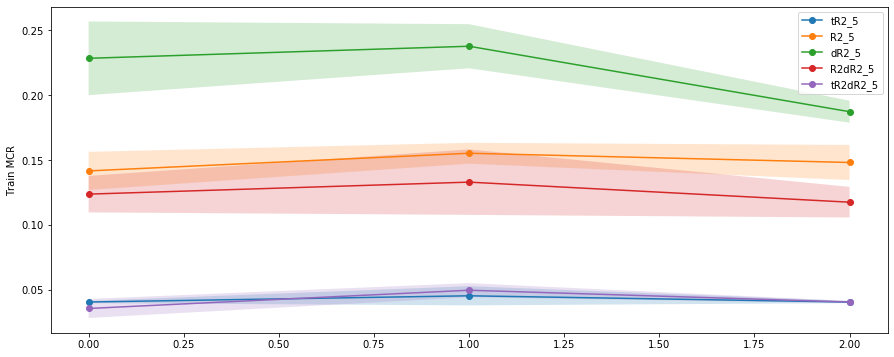

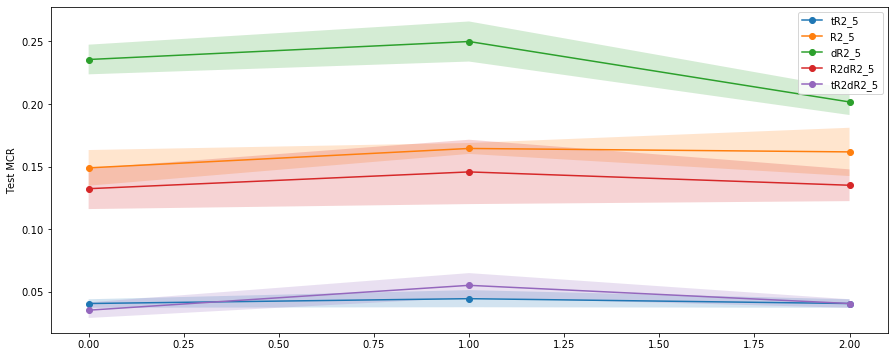

In [5]:
# Compare setPrim for solo
# TODO bar plot

max_tree_depth = 5
window_size = 75
feature_source = 'solo'

feature_types = [
    'tR2',
    'R2',
    'dR2',
    'R2dR2',
    'tR2dR2',
]
primitives_sets = [
    'setPrim1',
    'setPrim2',
    'setPrim12'
]
# Unpruned
# for partition in ['train', 'test']:
#     plt.figure(figsize=[15,6])
#     for feature_type in feature_types:
#         for max_tree_depth in max_tree_depths:
#             means = np.array([ cv_results[feature_type][window_size][max_tree_depth][f'{partition}_mcrs_mean'] for window_size in window_sizes ])
#             stds = np.array([ cv_results[feature_type][window_size][max_tree_depth][f'{partition}_mcrs_std'] for window_size in window_sizes ])
#             plt.plot(window_sizes, means, 'o-', label=feature_type + '_' + str(max_tree_depth))
#             plt.fill_between(window_sizes,  means - stds,  means + stds, alpha=.2)
#     plt.xlabel('Window size (# frames)')
#     plt.ylabel(f'{partition.capitalize()} MCR')
#     plt.xticks(window_sizes, window_sizes) #, rotation=45)
#     plt.legend()
#     plt.show()


# Pruned
# for feature_type in feature_types:
#     for partition in ['train', 'test']:
#         plt.figure(figsize=[15,6])
#         for max_tree_depth in max_tree_depths:
#             means = np.array([ cv_results[feature_type][window_size][max_tree_depth][f'{partition}_mcrs_pruned_mean'] for window_size in window_sizes ])
#             stds = np.array([ cv_results[feature_type][window_size][max_tree_depth][f'{partition}_mcrs_pruned_std'] for window_size in window_sizes ])
#             plt.plot(window_sizes, means, 'o-', label=feature_type + '_' + str(max_tree_depth))
#             plt.fill_between(window_sizes,  means - stds,  means + stds, alpha=.2)
#         plt.xlabel('Window size (# frames)')
#         plt.ylabel(f'{partition.capitalize()} MCR')
#         plt.xticks(window_sizes, window_sizes) #, rotation=45)
#         plt.ylim(0, 0.4)
#         plt.legend()
#         plt.show()
ps = np.arange(len(primitives_sets))


for partition in ['train', 'test']:
    plt.figure(figsize=[15,6])
    for feature_type in feature_types:

        means = np.array([ res[p][feature_type][window_size][max_tree_depth][f'{partition}_mcrs_pruned_mean'] for p in primitives_sets ])
        stds = np.array([ res[p][feature_type][window_size][max_tree_depth][f'{partition}_mcrs_pruned_std'] for p in primitives_sets ])
        plt.plot(ps, means, 'o-', label=feature_type + '_' + str(max_tree_depth))
        plt.fill_between(ps,  means - stds,  means + stds, alpha=.2)
    #plt.xlabel('Window size (# frames)')
    plt.ylabel(f'{partition.capitalize()} MCR')
    #plt.xticks(window_sizes, window_sizes) #, rotation=45)
    # plt.ylim(0, 0.25)
    # plt.ylim(0, 0.4)
    plt.legend()
    plt.show()
